In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import math
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

## 1. Time Series Classification
## (a) Download the data.

In [2]:
## data cleaning
def cleanData(filePath) :
    f = open(filePath, "r")
    instance = ''
    lineNum = 1
    line = f.readline()
    time = 0
    spaceSep = 0
    missingValues = []

    while line:
        if lineNum >= 6:
            if line.find(str(time)) == -1: #missing row
                instance += (str(time)+',,,,,,\n')
                time = time + 250
            elif line.find(str(',')) == -1: # not separated with ',' 
                spaceSep = 1
            elif line[-1] == ',' :
                line = line[:-1]
            time = time + 250

        instance += line
        lineNum = lineNum + 1
        line = f.readline()
    f.close()
    
    
    instance = StringIO(instance)
    return spaceSep, instance

def dealMissing(df):
    for col in df.columns :
        if df[[col]].isnull().values.any() :
            inds = pd.isnull(df).to_numpy().any(1).nonzero()[0]
            df.loc[inds[0],col] = df[col].mean()
    return df

In [3]:
def loadFiles(folderPath, length, className) :
    classSet = []
    classDf = pd.DataFrame(columns=['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])
    for i in range(length):
        filePath = folderPath + str(i+1) + '.csv'
        spaceSep, instance = cleanData(filePath)
        if spaceSep: 
            instanceDf = pd.read_csv(instance, header=4, sep = " ", index_col=False, names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])
        else:
            instanceDf = pd.read_csv(instance, header=4, index_col=False, names = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23'])
        instanceDf['class'] = className
        if instanceDf.isnull().values.any():
            instanceDf = dealMissing(instanceDf)
        classSet.append(instanceDf)
        classDf = classDf.append(instanceDf, ignore_index=True, sort=False)
    classDf['class'] = className
    return classDf, classSet

In [4]:
bending1, bending1Set = loadFiles('AReM/bending1/dataset', 7, 'bending1')
bending2, bending2Set = loadFiles('AReM/bending2/dataset', 6, 'bending2')
cycling, cyclingSet = loadFiles('AReM/cycling/dataset', 15, 'cycling')
lying, lyingSet = loadFiles('AReM/lying/dataset', 15, 'lying')
sitting, sittingSet = loadFiles('AReM/sitting/dataset', 15, 'sitting')
standing, standingSet = loadFiles('AReM/standing/dataset', 15, 'standing')
walking, walkingSet = loadFiles('AReM/walking/dataset', 15, 'walking')   

## (b)Keep datasets 1 and 2 in folders bending1 and bending2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [5]:
testSetsDf = pd.concat([bending1.loc[:959,:], bending2.loc[:959,:], cycling.loc[:1439, :], lying.loc[:1439, :]
                        , sitting.loc[:1439, :], standing.loc[:1439, :], walking.loc[:1439, :]], ignore_index=True)
trainSetsDf = pd.concat([bending1.loc[960:,:], bending2.loc[960:,:], cycling.loc[960:, :], lying.loc[1440:, :]
                        , sitting.loc[1440:, :], standing.loc[1440:, :], walking.loc[1440:, :]], ignore_index=True)
print ('test set : \n', testSetsDf.head())
#print (testSetsDf.tail(), '\n')
print ('train set : \n', trainSetsDf.head())
#print (trainSetsDf.tail(), '\n')

test set : 
    time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0     0      39.25       0.43      22.75       0.43      33.75        1.3   
1   250      39.25       0.43      23.00       0.00      33.00        0.0   
2   500      39.25       0.43      23.25       0.43      33.00        0.0   
3   750      39.50       0.50      23.00       0.71      33.00        0.0   
4  1000      39.50       0.50      24.00       0.00      33.00        0.0   

      class  
0  bending1  
1  bending1  
2  bending1  
3  bending1  
4  bending1  
train set : 
    time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  var_rss23  \
0     0      42.00       0.71      21.25       0.43      30.00       0.00   
1   250      41.50       0.50      20.25       1.48      31.25       1.09   
2   500      41.50       0.50      14.25       1.92      33.00       0.00   
3   750      40.75       0.83      15.75       0.43      33.00       0.00   
4  1000      40.00       0.71      20.00 

## (c) Feature Extraction

## i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

### Answer : correlation, distribution, entropy, variance, minimum, maximum, mean, median, mode, standard deviation, first quartile, third quartile, inter-quartile, range

## ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [6]:
def extractFeatures(classSets, instanceIdx, className) :
    columnName = bending1.columns[1:7]
    instanceRow = [None for i in range(44)]
    
    classSetsDf = pd.DataFrame(columns=['instance', 'min1', 'max1', 'mean1', 'median1', 'std1', '1st quart1', '3rd quart1'
                                   , 'min2', 'max2', 'mean2', 'median2', 'std2', '1st quart2', '3rd quart2'
                                   , 'min3', 'max3', 'mean3', 'median3', 'std3', '1st quart3', '3rd quart3'
                                   , 'min4', 'max4', 'mean4', 'median4', 'std4', '1st quart4', '3rd quart4'
                                   , 'min5', 'max5', 'mean5', 'median5', 'std5', '1st quart5', '3rd quart5'
                                   , 'min6', 'max6', 'mean6', 'median6', 'std6', '1st quart6', '3rd quart6', 'class'])
    
    for i in range(len(classSets)):
        colNum = 0
        instanceRow[colNum] = instanceIdx
        instanceIdx += 1
        colNum += 1
        
        for col in columnName:
            instanceRow[colNum] = classSets[i].loc[:,col].min()
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].max()
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].mean()
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].median()
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].std()
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].quantile(.25)
            colNum += 1
            instanceRow[colNum] = classSets[i].loc[:,col].quantile(.75)
            if colNum < 43:
                colNum += 1
            if colNum == 43:
                instanceRow[colNum] = className
        classSetsDf.loc[len(classSetsDf)] = instanceRow
    return classSetsDf


In [7]:
newDataSetDf = extractFeatures(bending1Set, 1, 'bending1')
newDataSetDf = newDataSetDf.append(extractFeatures(bending2Set, len(newDataSetDf)+1, 'bending2'), ignore_index = True)
newDataSetDf = newDataSetDf.append(extractFeatures(cyclingSet, len(newDataSetDf)+1, 'cycling'), ignore_index = True)
newDataSetDf = newDataSetDf.append(extractFeatures(lyingSet, len(newDataSetDf)+1, 'lying'), ignore_index = True)
newDataSetDf = newDataSetDf.append(extractFeatures(sittingSet, len(newDataSetDf)+1, 'sitting'), ignore_index = True)
newDataSetDf = newDataSetDf.append(extractFeatures(standingSet, len(newDataSetDf)+1, 'standing'), ignore_index = True)
newDataSetDf = newDataSetDf.append(extractFeatures(walkingSet, len(newDataSetDf)+1, 'walking'), ignore_index = True)
newDataSetDf['instance'] = newDataSetDf['instance'].apply(np.int64)
#print(newDataSetDf.iloc[:, 0:43])
#print(newDf)
#newDataSet.append(extractFeatures(bending1))
#print('\n min\n',sittingSet[0].loc[:, 'avg_rss12'].min())


print(newDataSetDf)

    instance   min1   max1      mean1  median1      std1  1st quart1  \
0          1  37.25  45.00  40.624792   40.500  1.476967     39.2500   
1          2  38.00  45.67  42.812812   42.500  1.435550     42.0000   
2          3  35.00  47.40  43.954500   44.330  1.558835     43.0000   
3          4  33.00  47.75  42.179813   43.500  3.670666     39.1500   
4          5  33.00  45.75  41.678063   41.750  2.243490     41.3300   
5          6  37.00  48.00  43.454958   43.250  1.386098     42.5000   
6          7  36.25  48.00  43.969125   44.500  1.618364     43.3100   
7          8  12.75  51.00  24.562958   24.250  3.737514     23.1875   
8          9   0.00  42.75  27.464604   28.000  3.583582     25.5000   
9         10  21.00  50.00  32.586208   33.000  6.238143     26.1875   
10        11  27.50  33.00  29.881938   30.000  1.153837     29.0000   
11        12  19.00  45.50  30.938104   29.000  7.684146     26.7500   
12        13  25.00  47.50  31.058250   29.710  4.829794     27.

## iii. Estimate the standard deviation of each of the time-domain features. 

In [8]:
stdSets = []
meanSets = []
for col in newDataSetDf.columns[1:43] :
    stdSets.append(newDataSetDf[col].std())
    meanSets.append(newDataSetDf[col].mean())
    
#print(stdSets)
std_MeanSetsDf = pd.DataFrame([stdSets, meanSets], columns=['min1', 'max1', 'mean1', 'median1', 'std1', '1st quart1', '3rd quart1'
                                   , 'min2', 'max2', 'mean2', 'median2', 'std2', '1st quart2', '3rd quart2'
                                   , 'min3', 'max3', 'mean3', 'median3', 'std3', '1st quart3', '3rd quart3'
                                   , 'min4', 'max4', 'mean4', 'median4', 'std4', '1st quart4', '3rd quart4'
                                   , 'min5', 'max5', 'mean5', 'median5', 'std5', '1st quart5', '3rd quart5'
                                   , 'min6', 'max6', 'mean6', 'median6', 'std6', '1st quart6', '3rd quart6'], index = ['std', 'mean'])
#print (std_MeanSetsDf)
print (std_MeanSetsDf.loc['std'])

min1          9.569975
max1          4.394362
mean1         5.335718
median1       5.440054
std1          1.772166
1st quart1    6.153590
3rd quart1    5.138925
min2          0.000000
max2          5.062729
mean2         1.574164
median2       1.412244
std2          0.884108
1st quart2    0.946386
3rd quart2    2.125266
min3          2.956462
max3          4.875137
mean3         4.008380
median3       4.036396
std3          0.946695
1st quart3    4.220658
3rd quart3    4.171628
min4          0.000000
max4          2.183625
mean4         1.166114
median4       1.145586
std4          0.458248
1st quart4    0.843620
3rd quart4    1.552504
min5          6.124001
max5          5.741238
mean5         5.675593
median5       5.813782
std5          1.024870
1st quart5    6.096465
3rd quart5    5.531720
min6          0.045838
max6          2.518921
mean6         1.154812
median6       1.086474
std6          0.517623
1st quart6    0.758584
3rd quart6    1.523599
Name: std, dtype: float64


## iii. Use Python's bootstrapped or any other method to build a 90% bootstrap confidence interval for the standard deviation of each feature.

In [9]:
from sklearn.utils import resample

columns = newDataSetDf.columns[1:43]
#stds = []
j = 0
for col in columns :
    stds = []
    for i in range(100):
        sample = resample(newDataSetDf[col], n_samples=len(newDataSetDf[col]), random_state=i)
        stds.append(sample.values.std())
        stds.sort()

    #confidence interval 90%
    ci = int(len(stds) * 0.1 /2)
    ci_s = stds[ci]
    ci_e = stds[len(stds)-1-ci]
    j = j+1

    print (j,'. ', col, 'confidence interval 90% : [', ci_s,",", ci_e, ']')

1 .  min1 confidence interval 90% : [ 8.243737188976192 , 10.692935346401102 ]
2 .  max1 confidence interval 90% : [ 3.464921601127912 , 5.2108206859451975 ]
3 .  mean1 confidence interval 90% : [ 4.6495122978070125 , 5.685374731741494 ]
4 .  median1 confidence interval 90% : [ 4.772465425717553 , 5.792809095135174 ]
5 .  std1 confidence interval 90% : [ 1.5633617938440751 , 1.9431587974057858 ]
6 .  1st quart1 confidence interval 90% : [ 5.53999312258266 , 6.472226798950612 ]
7 .  3rd quart1 confidence interval 90% : [ 4.2798683622044145 , 5.654669089831505 ]
8 .  min2 confidence interval 90% : [ 0.0 , 0.0 ]
9 .  max2 confidence interval 90% : [ 4.595994178312977 , 5.314117443373153 ]
10 .  mean2 confidence interval 90% : [ 1.3795566640235672 , 1.7007811534277868 ]
11 .  median2 confidence interval 90% : [ 1.2086167420797782 , 1.546127272533507 ]
12 .  std2 confidence interval 90% : [ 0.800389767135867 , 0.9331225448293748 ]
13 .  1st quart2 confidence interval 90% : [ 0.8059897154974

## iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, mean, and max)

### Answer : mean, std, median, those three are important factors to see the distiribution of data.

## (d) Binary Classification Using Logistic Regression.

### i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instances, and use color to distinguish bending vs. other activities.

In [10]:
# train set, test set
newTestSetsDf = pd.concat([newDataSetDf.iloc[0:2,:], newDataSetDf.iloc[7:9,:], newDataSetDf.iloc[13:16, :], newDataSetDf.iloc[28:31, :]
                        , newDataSetDf.iloc[43:46, :], newDataSetDf.iloc[58:61, :], newDataSetDf.iloc[73:76, :]], ignore_index=True)
newTrainSetsDf = pd.concat([newDataSetDf.iloc[2:7,:], newDataSetDf.iloc[9:13,:], newDataSetDf.iloc[16:28, :], newDataSetDf.iloc[31:43, :]
                        , newDataSetDf.iloc[46:58, :], newDataSetDf.iloc[61:73, :], newDataSetDf.iloc[76:, :]], ignore_index=True)
# train set with time series 1,2,6
trainSets_126 = newTrainSetsDf[['instance','mean1', 'median1', 'std1', 'mean2', 'median2', 'std2', 'mean6', 'median6', 'std6', 'class']]

# bending->1, other class->0
trainSets_126['class'].mask(trainSets_126['class'] == 'bending1', 'bending', inplace=True)
warnings.filterwarnings("ignore")
trainSets_126['class'].mask(trainSets_126['class'] == 'bending2', 'bending', inplace=True)
warnings.filterwarnings("ignore")
trainSets_126['class'].mask(trainSets_126['class'] != 'bending', 'no bending', inplace=True)
warnings.filterwarnings("ignore")
#trainSets_126.loc[:,'class'] = trainSets_126.loc[:,'class'] =='bending2', 'yes', 'no'

#print(trainSets_126)
#print(newTrainSetsDf)


#print (newTestSetsDf)
#print (newTestSetsDf.describe())
#print (newTrainSetsDf)
#print (newTrainSetsDf.describe())

/Users/RyooSeongoh/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


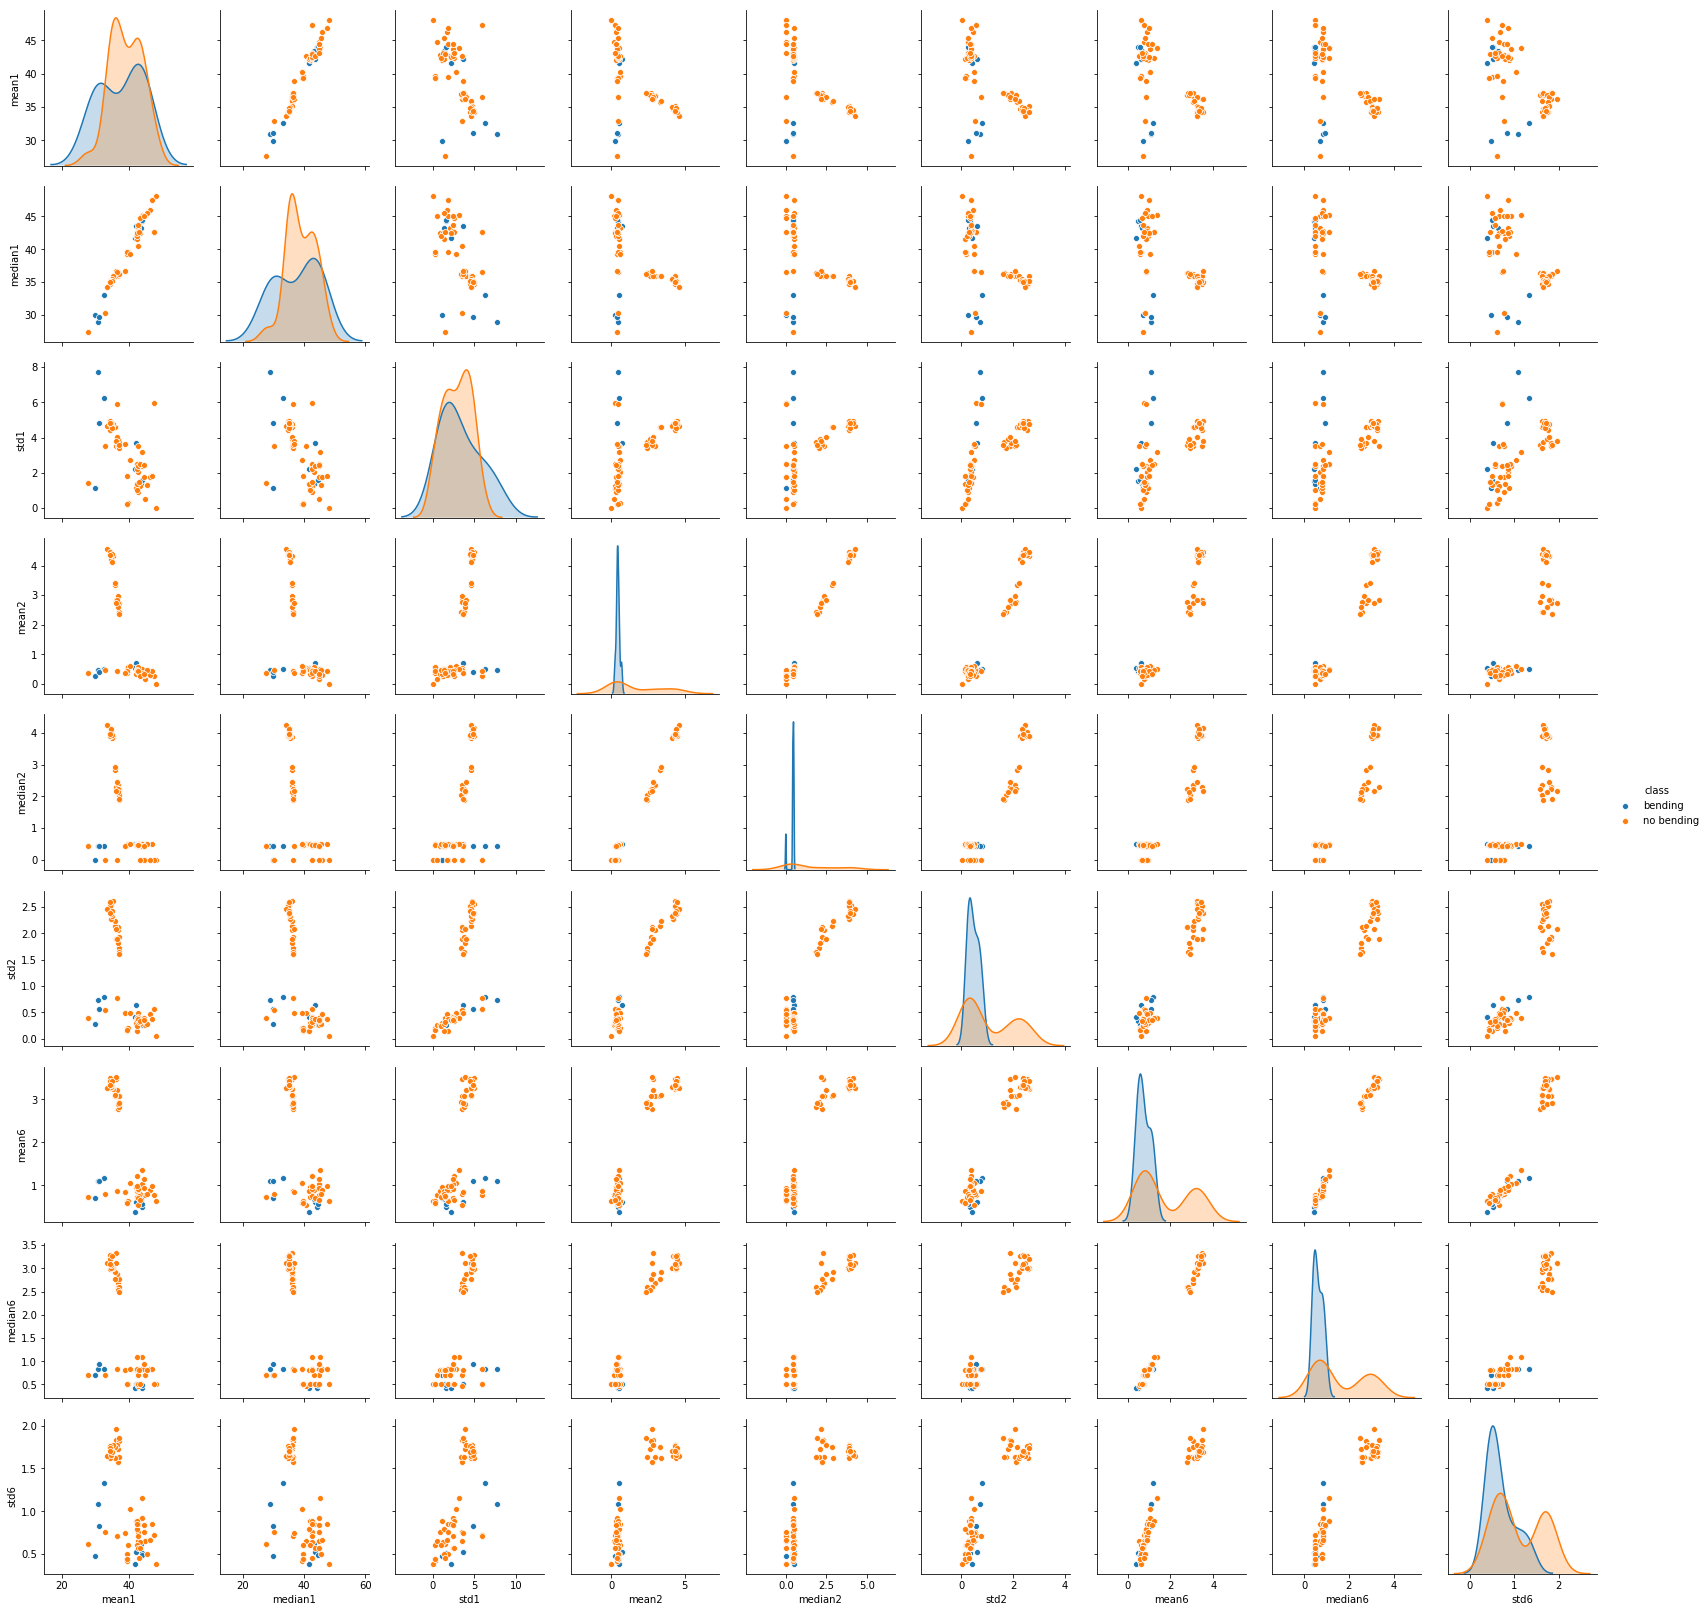

In [11]:
sc1_plot = sns.pairplot(trainSets_126, vars=['mean1', 'median1', 'std1', 'mean2', 'median2', 'std2', 'mean6', 'median6', 'std6'], hue='class')
#sc2_plot = sns.pairplot(trainSets_126, vars=['mean2', 'median2', 'std2'], hue='class')
#sc6_plot = sns.pairplot(trainSets_126, vars=['mean6', 'median6', 'std6'], hue='class')

## ii. Break each time series in your training set into two (approximate) equal length time series. -> 12 time series. Repeat 1(d)i. depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

### Answer : No, it looks almost same with the scatter plot in d(i).

In [12]:
def breakIntoTwo_1212(classSet, start) :
    instanceSet = []
    for i in range(start, len(classSet)):
        mean1 = classSet[i]['avg_rss12'].iloc[0:240].mean()
        median1 = classSet[i]['avg_rss12'].iloc[0:240].median()
        std1 = classSet[i]['avg_rss12'].iloc[0:240].std()
        
        mean2 = classSet[i]['var_rss12'].iloc[0:240].mean()
        median2 = classSet[i]['var_rss12'].iloc[0:240].median()
        std2 = classSet[i]['var_rss12'].iloc[0:240].std()
        
        mean12 = classSet[i]['var_rss23'].iloc[240:].mean()
        median12 = classSet[i]['var_rss23'].iloc[240:].median()
        std12 = classSet[i]['var_rss23'].iloc[240:].std()
        
        className = ('no bending','bending')[classSet[i]['class'].iloc[0] == 'bending1' or classSet[i]['class'].iloc[0] == 'bending2'] 
        instanceSet.append([mean1, median1, std1, mean2, median2, std2, mean12, median12, std12, className])
    instanceSetDf = pd.DataFrame(instanceSet, columns = ['mean1', 'median1', 'std1', 'mean2', 'median2', 'std2', 'mean12', 'median12', 'std12', 'class'])
    return instanceSetDf

twoDividedInstances = breakIntoTwo_1212(bending1Set, 2)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(bending2Set, 2), ignore_index = True)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(cyclingSet, 3), ignore_index = True)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(lyingSet, 3), ignore_index = True)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(sittingSet, 3), ignore_index = True)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(standingSet, 3), ignore_index = True)
twoDividedInstances = twoDividedInstances.append(breakIntoTwo_1212(walkingSet, 3), ignore_index = True)

print(twoDividedInstances.count())
#print(twoDividedInstances)

mean1       69
median1     69
std1        69
mean2       69
median2     69
std2        69
mean12      69
median12    69
std12       69
class       69
dtype: int64


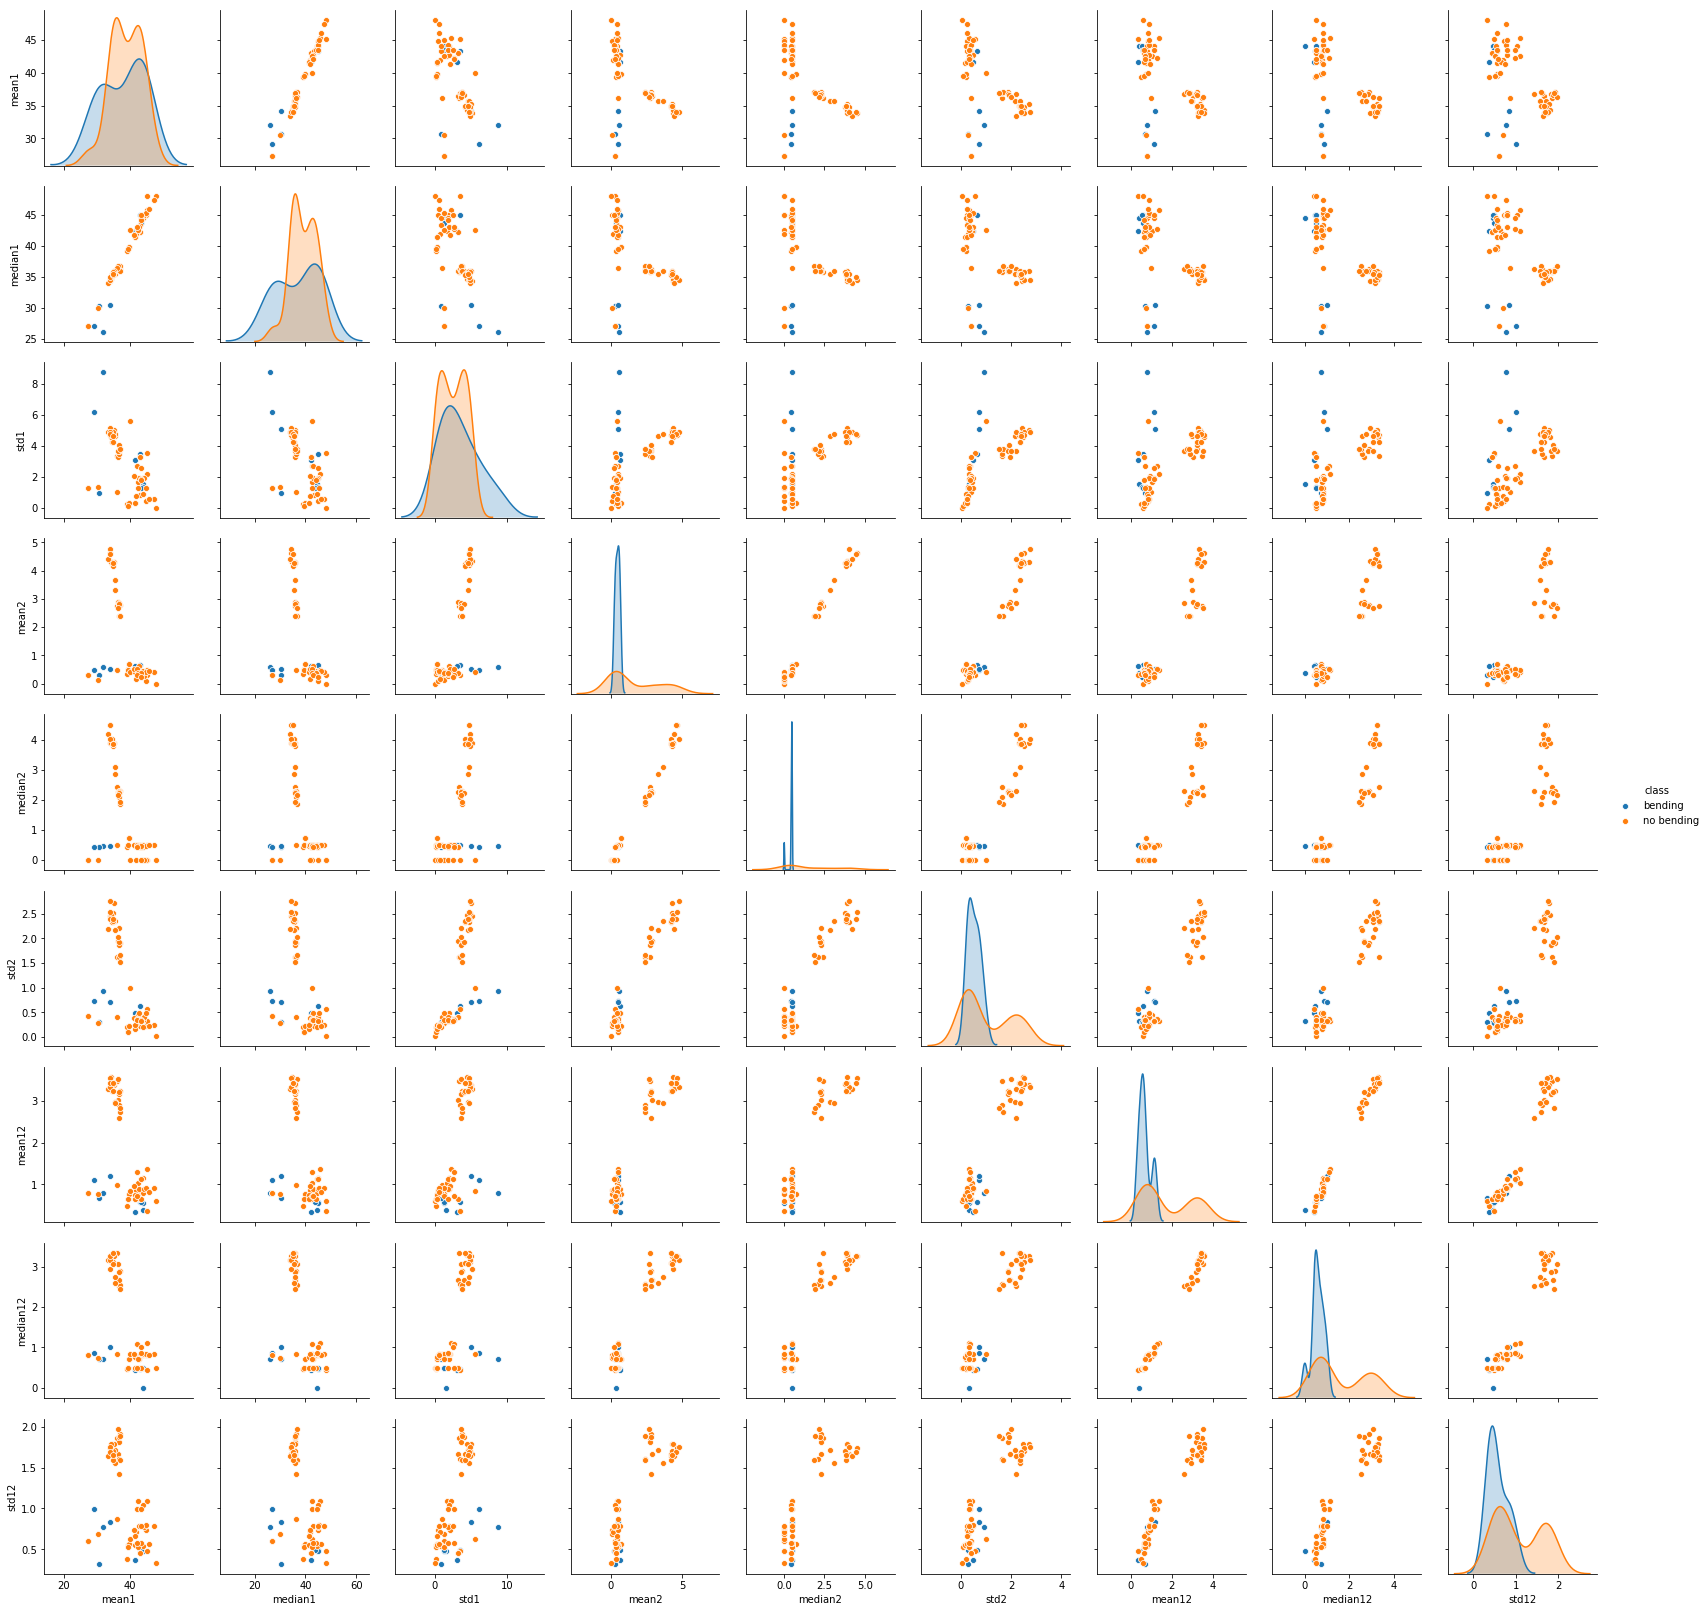

In [13]:
twoDivided_plot = sns.pairplot(twoDividedInstances, hue='class')

## iii. Break each time series in your training set into l-> (1,2,...,20) time series and use logistic regression to solve the binary classification problem, using time-domain features. Alternatively, you can use backward selection using sklearn.feature.selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l,p), where p is the number of features used in recursive feature elimination. 

In [14]:
def appendValues(arraySet, instances) :
    for i in range(len(arraySet)) :
        instances.append(arraySet[i])
    return instances

## l=[1,20] datasets 
def computeTrainTest(classSets, startInst, l_num, bend, instanceSets_x, instanceSets_y, instanceSets_y_multi):
    #print('in the def', instanceSets_x)
    num = 480/l_num #compute number of rows to be added from 0
    remaining = 480%l_num #remaining

    for i in range(startInst, len(classSets)) : #instance iteration
        oneInstance_x = []
        instanceSets_multi_y = []
        start = 0
        end = 0
        remaining = 480%l_num #remaining
        #print('fileNum: ', i, '')
        while end < 480 : #in one instsance
            if remaining == 0:
                end = int(start + num)
            elif remaining > 0:
                end = int(start+num+1)
                remaining = remaining - 1

            minValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].min()
            oneInstance_x = appendValues(minValue, oneInstance_x)
            maxValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].max()
            oneInstance_x = appendValues(maxValue, oneInstance_x)
            meanValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].mean()
            oneInstance_x = appendValues(meanValue, oneInstance_x)
            medianValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].median()
            oneInstance_x = appendValues(medianValue, oneInstance_x)
            stdValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].std()
            oneInstance_x = appendValues(stdValue, oneInstance_x)
            quantile1 = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].quantile(.25)
            oneInstance_x = appendValues(quantile1, oneInstance_x)
            quantile2 = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].quantile(.75)
            oneInstance_x = appendValues(quantile2, oneInstance_x)
            start = end
        instanceSets_x.append(oneInstance_x)
        instanceSets_y.append(bend)
        instanceSets_y_multi.append(classSets[0].loc[0, 'class'])
        
    return instanceSets_x, instanceSets_y, instanceSets_y_multi


In [16]:
trainXArr = []
trainYArr = []
trainYArr_multi = []
for i in range(1,21) :
    xTrain = []
    yTrain = []
    yTrainMulti = []

    xTrain, yTrain, yTrainMulti = computeTrainTest(bending1Set, 2, i, 1, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(bending2Set, 2, i, 1, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(cyclingSet, 3, i, 0, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(lyingSet, 3, i, 0, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(sittingSet, 3, i, 0, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(standingSet, 3, i, 0, xTrain, yTrain, yTrainMulti)
    xTrain, yTrain, yTrainMulti = computeTrainTest(walkingSet, 3, i, 0, xTrain, yTrain, yTrainMulti)
    xTrain = pd.DataFrame(xTrain)
    yTrain = pd.DataFrame(yTrain)
    yTrainMulti = pd.DataFrame(yTrainMulti)
    trainXArr.append(xTrain)
    trainYArr.append(yTrain)
    trainYArr_multi.append(yTrainMulti)


### max iteration number for logistic regression solver

In [17]:
def computeMaxIter(x_train, y_train):
    optScore = -1
    numIter = math.inf
    start = 4
    end = 12
    for i in range(0, 20) :
        for maxIter in range(start, end):
            model = LogisticRegression(max_iter=maxIter, C = 100000000.0)
            #warnings.filterwarnings("ignore")
            rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),scoring='accuracy')
            rfecv.fit(x_train[i],y_train[i])

            score = max(rfecv.grid_scores_)
            #print(i, maxIter, score)
            if score >= 1 :
                if (maxIter-1) < numIter :
                    end = maxIter
                    numIter = maxIter - 1
                break
    return numIter

maxNumIter = computeMaxIter(trainXArr, trainYArr)
print(maxNumIter)

5


In [18]:
def runRFECV (x_train, y_train):
    optScore = -1
    for i in range(0, 20) :
        model = LogisticRegression(C=100000000.0, max_iter=maxNumIter - 1)
        #warnings.filterwarnings("ignore")
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
        rfecv.fit(x_train[i],y_train[i])

        #print(rfecv.grid_scores_)
        score = max(rfecv.grid_scores_)
        if optScore < score :
            optL = i + 1
            optNumFeature = rfecv.n_features_
            optScore = score
            optFeatures = rfecv.support_
            params = rfecv.get_params
        print('L : ', i+1, ", Optimal number of features : %d" % rfecv.n_features_, ', accuracy : ', score)
    return optL, optNumFeature, optScore, optFeatures, params
    
optimalL, optimalNumFeature, optimalScore, optimalFeatures, parameters = runRFECV(trainXArr, trainYArr)

print('optimal L: ', optimalL, ', optimal number of features : ', optimalNumFeature, ', optimal Score : ',optimalScore, ', min Error rate : ', 1 - optimalScore)
#print('optimal L: ', optimalL + 1, 'optimal number of features : ', optimalNumFeature)
#print('optimal features : ', optimalFeatures)



L :  1 , Optimal number of features : 4 , accuracy :  0.9714285714285715
L :  2 , Optimal number of features : 3 , accuracy :  0.9571428571428571
L :  3 , Optimal number of features : 4 , accuracy :  0.9857142857142858
L :  4 , Optimal number of features : 4 , accuracy :  0.9714285714285715
L :  5 , Optimal number of features : 6 , accuracy :  0.9428571428571428
L :  6 , Optimal number of features : 16 , accuracy :  0.9714285714285715
L :  7 , Optimal number of features : 4 , accuracy :  0.9714285714285715
L :  8 , Optimal number of features : 3 , accuracy :  0.9560439560439562
L :  9 , Optimal number of features : 4 , accuracy :  0.9571428571428571
L :  10 , Optimal number of features : 6 , accuracy :  0.9571428571428571
L :  11 , Optimal number of features : 6 , accuracy :  0.9714285714285715
L :  12 , Optimal number of features : 15 , accuracy :  0.9857142857142858
L :  13 , Optimal number of features : 1 , accuracy :  0.9714285714285715
L :  14 , Optimal number of features : 13 , a

In [19]:
print('optimal (l,p) : (',optimalL, ',', optimalNumFeature, ')' )

optimal (l,p) : ( 3 , 4 )


## Explain what the right way and the wrong way are to perform cross-validation in this problem.
### Answer : 
### right way - apply cross validation on every pair of (l,p)
### wrong way - apply cross validation on l and the p or p and the l.

## Research what stratified cross validation means and use it if needed.
### Answer : Stratified cross validation ensures that the each test set and train set doesn't have imbalanced proportion of data compare to whole data so that it can reduce bias and variance.

## iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regresion Bi's as well as the p-values associated with them.

In [20]:
## split the test set
def getSplittedTest(classSets, endInst, l_num, bend, instanceSets_x, instanceSets_y):
    #print('in the def', instanceSets_x)
    num = 480/l_num #compute number of rows to be added from 0
    remaining = 480%l_num #remaining
    #oneInstance_x = [] #
    #start = 0
    #end = 0

    for i in range(0, endInst) : #instance iteration
        oneInstance_x = []
        start = 0
        end = 0
        remaining = 480%l_num #remaining
        #print('fileNum: ', i, '')
        while end < 480 : #in one instsance
            if remaining == 0:
                end = int(start + num)
            elif remaining > 0:
                end = int(start+num+1)
                remaining = remaining - 1

            minValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].min()
            oneInstance_x = appendValues(minValue, oneInstance_x)
            maxValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].max()
            oneInstance_x = appendValues(maxValue, oneInstance_x)
            meanValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].mean()
            oneInstance_x = appendValues(meanValue, oneInstance_x)
            medianValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].median()
            oneInstance_x = appendValues(medianValue, oneInstance_x)
            stdValue = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].std()
            oneInstance_x = appendValues(stdValue, oneInstance_x)
            quantile1 = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].quantile(.25)
            oneInstance_x = appendValues(quantile1, oneInstance_x)
            quantile2 = classSets[i].loc[start:end, 'avg_rss12':'var_rss23'].quantile(.75)
            oneInstance_x = appendValues(quantile2, oneInstance_x)
            #iter_index.append([start, end])
            start = end
            #oneInstance.append([minValue.values, maxValue.values, meanValue.values, medianValue.values, stdValue.values, quantile1.values, quantile2.values])
        #print(oneInstance_x)
        instanceSets_x.append(oneInstance_x)
        instanceSets_y.append(bend)
        
    return instanceSets_x, instanceSets_y

xTest = []
yTest = []
xTest, yTest = getSplittedTest(bending1Set, 2, optimalL, 1, xTest, yTest)
xTest, yTest = getSplittedTest(bending2Set, 2, optimalL, 1, xTest, yTest)
xTest, yTest = getSplittedTest(cyclingSet, 3, optimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(lyingSet, 3, optimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(sittingSet, 3, optimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(standingSet, 3, optimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(walkingSet, 3, optimalL, 0, xTest, yTest)
xTest = pd.DataFrame(xTest)

print(xTest.head(), '\n')
print(yTest)
print('num of instances : ', len(xTest), ', num of instances : ', len(yTest))

     0    1     2    3     4    5      6     7      8     9    ...      116  \
0  38.75  0.0  4.00  0.0  32.5  0.0  42.33  1.22  24.00  7.23  ...  18.7500   
1  41.75  0.0  7.00  0.0  30.0  0.0  44.25  0.94  25.33  5.50  ...  17.9375   
2  12.75  0.0  5.67  0.0  15.2  0.0  27.00  6.76  24.75  4.82  ...  18.2500   
3  26.50  0.0  7.50  0.0  12.5  0.0  30.00  0.94  24.00  5.76  ...  19.9375   
4  29.33  0.0  8.50  0.0   7.0  0.0  44.50  8.18  26.75  8.05  ...  14.0000   

    117     118   119      120   121      122     123    124     125  
0  0.43  30.000  0.00  42.0000  0.50  24.2500  1.2275  36.00  0.8300  
1  0.43  30.000  0.00  45.0000  0.50  24.0000  1.4275  33.00  0.5000  
2  0.00  19.500  0.47  26.7500  0.47  22.7500  0.8875  21.75  1.0000  
3  0.43  10.645  0.71  26.0000  0.87  26.8125  1.5000  22.00  2.5225  
4  1.50  18.000  1.30  40.0625  3.05  18.0000  3.5800  21.50  3.6950  

[5 rows x 126 columns] 

[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
num of instance

optimal p :  [10, 34, 40, 90]
optimal train set : 
       10     34     40     90
0  38.50  36.00  37.00  47.40
1  38.67  36.00  37.25  45.25
2  35.75  27.50  30.00  42.50
3  33.50  22.75  25.00  46.50
4  30.75  21.00  28.00  48.00
confusion matrix : 
 [[60  0]
 [ 1  8]]
logistic regression coefficients(Bi) :  [[ 0.28177696  0.25873911  0.21385857 -0.40789625]]
         Current function value: 0.033498
         Iterations: 4
                           Logit Regression Results                           
Dep. Variable:                      0   No. Observations:                   69
Model:                          Logit   Df Residuals:                       64
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:                  0.9135
Time:                        23:27:15   Log-Likelihood:                -2.3114
converged:                      False   LL-Null:                       -26.718
                  

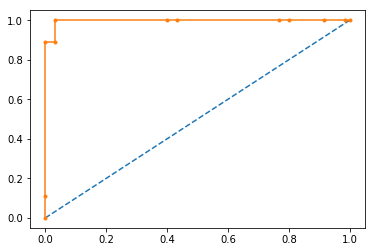

In [21]:
## create train data with optimal parameters
def getOptimalFeaturesNum(features):
    num_feature = []
    for i in range(len(features)):
        if features[i] == True:
            num_feature.append(i)
    return num_feature

## create data with optimal parameters
def getOptimalX(x, paramNum):
    newTrainX = x[paramNum]
    return newTrainX

## run Logistic Regression with optimal parameter
def runLogisticRegression(x_train, y_train, x_test, y_test) :
    model = LogisticRegression(max_iter=maxNumIter-1, C=100000000.0)
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_train)
    confusionMatrix = confusion_matrix(y_train, model.predict(x_train))
    coefficients = model.coef_
    testAccuracy = model.score(x_test,y_test)
    return probs, confusionMatrix, coefficients, testAccuracy
    
    
featureNums = getOptimalFeaturesNum(optimalFeatures)
print('optimal p : ', featureNums)
optTrainX = getOptimalX(trainXArr[optimalL-1], featureNums)
#print(optTrainX)
optTestX = getOptimalX(xTest, featureNums)
#print('test Set : ', optTestX)
print('optimal train set : \n', optTrainX.head())

##run logistic regression
probEstimate, cm, coef_betas, test_accuracy = runLogisticRegression(optTrainX, trainYArr[optimalL-1], optTestX, yTest)
print('confusion matrix : \n', cm)
#print(probEstimate)
probEstimate = probEstimate[:,1]
#print(probEstimate)


print('logistic regression coefficients(Bi) : ', coef_betas)
p_trainX = sm.add_constant(optTrainX)
#est = sm.OLS(trainYArr[optimalL-1], p_trainX)
#est = est.fit()
#estSummary = est.summary()
#print('p values:\n', est.pvalues)
#print(estSummary)
#print(est.summary(),'\n')

est_logmodel = sm.Logit(trainYArr[optimalL-1],p_trainX)
est_logmodel = est_logmodel.fit(maxiter=maxNumIter-1)
print(est_logmodel.summary())



## AUC, ROC
auc = roc_auc_score(trainYArr[optimalL-1], probEstimate)
fpr, tpr, thresholds = roc_curve(trainYArr[optimalL-1], probEstimate)
print('AUC: %.3f' % auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

## v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Comprare the accuracy on the test set with the cross-validation accuracy you obtained previously.

### Answer : cross-validation accuracy is higher than the test accuracy like below.

In [22]:
print('test data :\n', optTestX, '\n')
print('test accuracy : ', test_accuracy)
print('cv train accuracy : ', optimalScore)

test data :
        10     34     40     90
0   36.00  33.00  35.00  45.00
1   36.00  33.00  34.50  45.67
2   28.33  25.25  27.00  27.50
3   22.50  15.75  18.75  42.75
4   24.67  16.75  21.50  44.67
5   23.75  16.75  21.00  44.00
6   24.25  18.67  21.75  44.00
7   12.50   8.50  10.00  30.00
8   12.75   5.00  10.50  48.00
9   10.25   2.00   5.00  48.25
10  17.50   7.50  12.50  48.00
11  23.67  14.75  21.00  46.67
12  26.75  16.50  21.75  45.25
13  22.60  16.00  19.75  45.00
14  18.50  12.25  16.25  46.25
15  21.00  15.00  18.33  47.00
16  25.00  14.50  18.67  42.75
17  25.00  14.00  18.00  43.25
18  23.75  14.00  18.25  46.75 

test accuracy :  0.9473684210526315
cv train accuracy :  0.9857142857142858


## vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

### Answer : Yes, they seem to be linearly separable before setting max iteraion number of solver more than 4. After changing the max iteration number to 4, it seems a little bit better but still it's well-separated.

## vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model

### Answer : Yes, I could see class imbalance. Positive cases are much smaller than the negative cases.
### P(positive) = 13%, P(negative) = 87%

In [23]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

positive = TP + FN
negative = TN + FP
total = positive + negative

print ('p(positive): ', positive/total,', p(negative): ', negative/total )


########
#optTrainX, trainYArr[optimalL-1], optTestX, yTest

p(positive):  0.13043478260869565 , p(negative):  0.8695652173913043


confusion matrix : 
 [[58  2]
 [ 0 60]]
AUC: 0.998


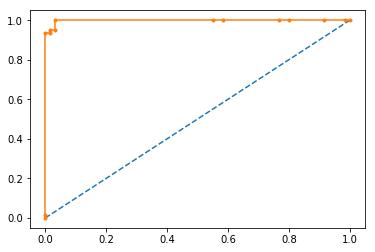

In [24]:
!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from collections import Counter

#print(sorted(Counter(trainYArr[optimalL-1]).items()))

smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(optTrainX, trainYArr[optimalL-1])

smote = SMOTE(random_state=2)
X_train_res, y_train_res = smote.fit_sample(optTrainX, trainYArr[optimalL-1])

probEstimateSMOTE, cmSMOTE, coef_betasSMOTE, test_accuracySMOTE = runLogisticRegression(X_train_res, y_train_res, optTestX, yTest)

print('confusion matrix : \n', cmSMOTE)
#print(probEstimate)
probEstimateSMOTE = probEstimateSMOTE[:,1]
#print(probEstimate)

## AUC, ROC
auc_smote = roc_auc_score(y_resampled, probEstimateSMOTE)
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_resampled, probEstimateSMOTE)
print('AUC: %.3f' % auc_smote)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_smote, tpr_smote, marker='.')
plt.show()

## (e) Binary Classification using L1-penalized logistic regression.

## (i) Repeat 1(d)iii using L1-penalized logistic regression. i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and lamda, the weight of L1 penalty in your logistic regression objective functino (or C, the budget). Packages uaually perform cross-validation for lamda automatically.

In [29]:
def runPenaltyCV(x_train, y_train, multi):
    optScore = -1
    for i in range(0, 20) :
        if multi == 'multinomial':
            model = LogisticRegressionCV(penalty='l1', max_iter=maxNumIter-1, solver='saga', multi_class=multi, cv=StratifiedKFold(5,shuffle=True,random_state=0), scoring='accuracy')
        else : 
            model = LogisticRegressionCV(penalty='l1', max_iter=maxNumIter-1, solver='liblinear', multi_class=multi, cv=StratifiedKFold(5,shuffle=True,random_state=0), scoring='accuracy')
        warnings.filterwarnings("ignore")
        ## standardization
        scaler = StandardScaler()
        standardizedX = scaler.fit_transform(x_train[i])
        model.fit(standardizedX,y_train[i])
        score = model.score(standardizedX, y_train[i])
        
        if optScore < score :
            optL = i + 1
            optScore = score
        print('L : ', i+1, ', accuracy : ', score)

    #return optL, optNumFeature, optScore, optFeatures, params
    return optL,optScore
    


In [30]:
pOptimalL, pOptimalScore = runPenaltyCV(trainXArr, trainYArr, 'ovr')
print('optimal L: ', pOptimalL, ', optimal Score : ',pOptimalScore)


L :  1 , accuracy :  1.0
L :  2 , accuracy :  0.9710144927536232
L :  3 , accuracy :  0.9710144927536232
L :  4 , accuracy :  1.0
L :  5 , accuracy :  0.9855072463768116
L :  6 , accuracy :  0.9710144927536232
L :  7 , accuracy :  0.9855072463768116
L :  8 , accuracy :  0.9855072463768116
L :  9 , accuracy :  1.0
L :  10 , accuracy :  1.0
L :  11 , accuracy :  1.0
L :  12 , accuracy :  1.0
L :  13 , accuracy :  1.0
L :  14 , accuracy :  0.9855072463768116
L :  15 , accuracy :  1.0
L :  16 , accuracy :  1.0
L :  17 , accuracy :  1.0
L :  18 , accuracy :  1.0
L :  19 , accuracy :  1.0
L :  20 , accuracy :  1.0
optimal L:  1 , optimal Score :  1.0


## ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

### Answer : When I used same max iteration number on logistic regression solver, train accuracy is higher in L-1 penalized and always gave me 1 even though I lowered max_iter. However, in most cases of run, the test accuracies are the same in both case so it seems both performs well but sometimes, L-1 penalized test accuracy is higher than the other one. In terms of implementation, the difficulty was same to me.

In [35]:
def runLogisticRegressionPenalty(x_train, y_train, x_test, y_test) :
    model = LogisticRegression(penalty='l1', max_iter=maxNumIter-1, C=100000000.0, solver='liblinear',multi_class='ovr')
    scaler = StandardScaler()
    standardizedTrainX = scaler.fit_transform(x_train)
    standardizedTestX = standardizedX = scaler.fit_transform(x_test)
    
    model.fit(standardizedTrainX, y_train)
    probs = model.predict_proba(standardizedTrainX)
    #confusionMatrix = confusion_matrix(y_train, model.predict(x_train))
    #coefficients = model.coef_
    testAccuracy = model.score(standardizedTestX,y_test)
    return testAccuracy

## test set
xTest = []
yTest = []
xTest, yTest = getSplittedTest(bending1Set, 2, pOptimalL, 1, xTest, yTest)
xTest, yTest = getSplittedTest(bending2Set, 2, pOptimalL, 1, xTest, yTest)
xTest, yTest = getSplittedTest(cyclingSet, 3, pOptimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(lyingSet, 3, pOptimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(sittingSet, 3, pOptimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(standingSet, 3, pOptimalL, 0, xTest, yTest)
xTest, yTest = getSplittedTest(walkingSet, 3, pOptimalL, 0, xTest, yTest)
xTest = pd.DataFrame(xTest)

#pOptTrainX = getOptimalX(trainXArr[pOptimalL-1], pFeatureNums)
#print(pOptTrainX.head())
#pOptTestX = getOptimalX(xTest, pFeatureNums)
#print(pOptTestX.head())
#pTestAccuracy = runLogisticRegressionPenalty(pOptTrainX, trainYArr[pOptimalL-1], pOptTestX, yTest)

pTestAccuracy = runLogisticRegressionPenalty(trainXArr[pOptimalL-1], trainYArr[pOptimalL-1], xTest, yTest)

print('L1-penalized optimal train accuracy : ', pOptimalScore)
print('variable selection using p value optimal train accuracy : ', optimalScore)

print('L1-penalized optimal test accuracy : ', pTestAccuracy)
print('variable selection using p value optimal test accuracy : ', test_accuracy)

L1-penalized optimal train accuracy :  1.0
variable selection using p value optimal train accuracy :  0.9857142857142858
L1-penalized optimal test accuracy :  0.9473684210526315
variable selection using p value optimal test accuracy :  0.9473684210526315


## (f) Multi-class Classification

## i. find the best l in the same way as you found it in 1(e)i to build an L1-penelized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrics and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [37]:
mOptimalL, mOptimalScore = runPenaltyCV(trainXArr, trainYArr_multi, 'ovr')
m2OptimalL, m2OptimalScore = runPenaltyCV(trainXArr, trainYArr_multi, 'multinomial')
# multinomial version
print('optimal L: ', mOptimalL, ', optimal Score : ',mOptimalScore)

#ovr version
print('optimal L2: ', m2OptimalL, ', optimal Score2 : ',m2OptimalScore)


L :  1 , accuracy :  0.9710144927536232
L :  2 , accuracy :  0.9855072463768116
L :  3 , accuracy :  1.0
L :  4 , accuracy :  0.9420289855072463
L :  5 , accuracy :  0.9565217391304348
L :  6 , accuracy :  0.9565217391304348
L :  7 , accuracy :  0.9855072463768116
L :  8 , accuracy :  0.9565217391304348
L :  9 , accuracy :  0.8985507246376812
L :  10 , accuracy :  0.9130434782608695
L :  11 , accuracy :  0.8985507246376812
L :  12 , accuracy :  0.9420289855072463
L :  13 , accuracy :  0.9130434782608695
L :  14 , accuracy :  0.8695652173913043
L :  15 , accuracy :  0.927536231884058
L :  16 , accuracy :  0.9420289855072463
L :  17 , accuracy :  0.9565217391304348
L :  18 , accuracy :  0.9855072463768116
L :  19 , accuracy :  0.927536231884058
L :  20 , accuracy :  0.8115942028985508
L :  1 , accuracy :  0.9855072463768116
L :  2 , accuracy :  1.0
L :  3 , accuracy :  1.0
L :  4 , accuracy :  1.0
L :  5 , accuracy :  0.9565217391304348
L :  6 , accuracy :  1.0
L :  7 , accuracy :  0.971

In [38]:
from sklearn.multiclass import OneVsRestClassifier

def runMultiLogisticRegression(x_train, y_train, x_test, y_test):
    model = LogisticRegression(penalty='l1', max_iter=maxNumIter-1, C=100000000.0, solver='liblinear',multi_class='ovr')
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_train)
    confusionMatrix = confusion_matrix(y_train, model.predict(x_train))
    #coefficients = model.coef_
    trainAccuracy = model.score(x_train, y_train)
    testAccuracy = model.score(x_test, y_test)
    #print('testAccuracy: ', testAccuracy)
    return probs, confusionMatrix, trainAccuracy, testAccuracy
    
## test set for 'ovr'
xTest = []
yTest = []
xTest, yTest = getSplittedTest(bending1Set, 2, mOptimalL, 'bending1', xTest, yTest)
xTest, yTest = getSplittedTest(bending2Set, 2, mOptimalL, 'bending2', xTest, yTest)
xTest, yTest = getSplittedTest(cyclingSet, 3, mOptimalL, 'cycling', xTest, yTest)
xTest, yTest = getSplittedTest(lyingSet, 3, mOptimalL, 'lying', xTest, yTest)
xTest, yTest = getSplittedTest(sittingSet, 3, mOptimalL, 'sitting', xTest, yTest)
xTest, yTest = getSplittedTest(standingSet, 3, mOptimalL, 'standing', xTest, yTest)
xTest, yTest = getSplittedTest(walkingSet, 3, mOptimalL, 'walking', xTest, yTest)
xTest = pd.DataFrame(xTest)

#mOptTrainX = getOptimalX(trainXArr[mOptimalL-1], mFeatureNums)
#print(mOptTrainX.head())
#mOptTestX = getOptimalX(xTest, mFeatureNums)
#print(mOptTestX.head())  



## test set for 'multinomial'
x2Test = []
y2Test = []
x2Test, y2Test = getSplittedTest(bending1Set, 2, m2OptimalL, 'bending1', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(bending2Set, 2, m2OptimalL, 'bending2', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(cyclingSet, 3, m2OptimalL, 'cycling', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(lyingSet, 3, m2OptimalL, 'lying', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(sittingSet, 3, m2OptimalL, 'sitting', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(standingSet, 3, m2OptimalL, 'standing', x2Test, y2Test)
x2Test, y2Test = getSplittedTest(walkingSet, 3, m2OptimalL, 'walking', x2Test, y2Test)
x2Test = pd.DataFrame(x2Test)

#m2OptTrainX = getOptimalX(trainXArr[m2OptimalL-1], m2FeatureNums)
#print(m2OptTrainX.head())
#m2OptTestX = getOptimalX(xTest, m2FeatureNums)
#print(m2OptTestX.head())    

    
    

#mFeatureNums = getOptimalFeaturesNum(mOptimalFeatures)
#print('optimal p : ', mFeatureNums)
#mOptTrainX = getOptimalX(trainXArr[mOptimalL-1], mFeatureNums)
#print(optTrainX)
#mOptTestX = getOptimalX(xTest, mFeatureNums)
#print('test Set : ', optTestX)
#print('optimal train set : \n', mOptTrainX.head())

mProbEstimate, m_cm, mTrain_accuracy, mTest_accuracy = runMultiLogisticRegression(trainXArr[mOptimalL-1], trainYArr_multi[mOptimalL-1], xTest, yTest)
m2ProbEstimate, m2_cm, m2Train_accuracy, m2Test_accuracy = runMultiLogisticRegression(trainXArr[m2OptimalL-1], trainYArr_multi[m2OptimalL-1], x2Test, y2Test)
## ovr mode
print('multiple class with ovr mode')
print('confusion matrix : \n', m_cm)
#print(probEstimate)
mProbEstimate = mProbEstimate[:,1]
#print(probEstimate)

## test error
print(mTest_accuracy)
print('test error : ', 1- mTest_accuracy)

## AUC, ROC
#m_auc = roc_auc_score(trainYArr_multi[mOptimalL-1], mProbEstimate)
#m_fpr, m_tpr, m_thresholds = roc_curve(trainYArr[mOptimalL-1], mProbEstimate)
#print('AUC: %.3f' % m_auc)
#plt.plot([0, 1], [0, 1], linestyle='--')
#plt.plot(m_fpr, m_tpr, marker='.')
#plt.show()

## multinomial mode
print('multiple class with multinomial mode')
print('confusion matrix : \n', m2_cm)
m2ProbEstimate = m2ProbEstimate[:,1]
print('test error2 : ', 1- m2Test_accuracy)

multiple class with ovr mode
confusion matrix : 
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]
0.7894736842105263
test error :  0.21052631578947367
multiple class with multinomial mode
confusion matrix : 
 [[ 5  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  0  0  0  0 12  0]
 [ 0  0  0  0  0  0 12]]
test error2 :  0.3157894736842105


## ii) Repeat 1(f)i using a Naive Bayes' classifer. Use both Gaussian and Multi-nomial priors and compare the results.

In [42]:
## Gaussian

from sklearn.naive_bayes import GaussianNB

def runNaiveGaussian(x_train, y_train):
    optScore = -1
    for i in range(0, 20) :
        model = GaussianNB()
        model.fit(x_train[i],y_train[i])
        score = model.score(x_train[i], y_train[i])
        if optScore < score :
            optL = i + 1
            optScore = score

        print('L : ', i+1, ', accuracy : ', score)
    return optL, optScore
    
gOptimalL, gOptimalScore =  runNaiveGaussian(trainXArr, trainYArr_multi)

print('optimal L: ', gOptimalL, ', optimal train accuracy : ',gOptimalScore, ', train error: ', 1-gOptimalScore)

def runGaussian(x_train, y_train, x_test, y_test):
    optScore = -1
    #for i in range(0, 20) :
    model = GaussianNB()
    model.fit(x_train,y_train)
    warnings.filterwarnings("ignore")
    score = model.score(x_test, y_test)
    print('test accuracy : ', score)
    return score

xTest = []
yTest = []
xTest, yTest = getSplittedTest(bending1Set, 2, gOptimalL, 'bending1', xTest, yTest)
xTest, yTest = getSplittedTest(bending2Set, 2, gOptimalL, 'bending2', xTest, yTest)
xTest, yTest = getSplittedTest(cyclingSet, 3, gOptimalL, 'cycling', xTest, yTest)
xTest, yTest = getSplittedTest(lyingSet, 3, gOptimalL, 'lying', xTest, yTest)
xTest, yTest = getSplittedTest(sittingSet, 3, gOptimalL, 'sitting', xTest, yTest)
xTest, yTest = getSplittedTest(standingSet, 3, gOptimalL, 'standing', xTest, yTest)
xTest, yTest = getSplittedTest(walkingSet, 3, gOptimalL, 'walking', xTest, yTest)
xTest = pd.DataFrame(xTest)

gTestScore =  runGaussian(trainXArr[gOptimalL-1], trainYArr_multi[gOptimalL-1], xTest, yTest)
print('Test Error : ', 1 - gTestScore)

L :  1 , accuracy :  1.0
L :  2 , accuracy :  1.0
L :  3 , accuracy :  0.9855072463768116
L :  4 , accuracy :  1.0
L :  5 , accuracy :  0.9855072463768116
L :  6 , accuracy :  0.9710144927536232
L :  7 , accuracy :  1.0
L :  8 , accuracy :  0.9710144927536232
L :  9 , accuracy :  1.0
L :  10 , accuracy :  1.0
L :  11 , accuracy :  1.0
L :  12 , accuracy :  1.0
L :  13 , accuracy :  1.0
L :  14 , accuracy :  1.0
L :  15 , accuracy :  1.0
L :  16 , accuracy :  1.0
L :  17 , accuracy :  1.0
L :  18 , accuracy :  1.0
L :  19 , accuracy :  1.0
L :  20 , accuracy :  1.0
optimal L:  1 , optimal train accuracy :  1.0 , train error:  0.0
test accuracy :  0.8947368421052632
Test Error :  0.10526315789473684


In [43]:
## multinomial
from sklearn.naive_bayes import MultinomialNB

def runNaiveMultinomialNB(x_train, y_train):
    optScore = -1
    for i in range(0, 20) :
        model = MultinomialNB()
        model.fit(x_train[i],y_train[i])

        score = model.score(x_train[i], y_train[i])
        if optScore < score :
            optL = i + 1
            optScore = score
        print('L : ', i+1, ', accuracy : ', score)
    return optL, optScore
    
bmOptimalL, bmOptimalScore =  runNaiveMultinomialNB(trainXArr, trainYArr_multi)

print('optimal L: ', bmOptimalL, ', optimal accuracy : ',bmOptimalScore, ', train error: ', 1-bmOptimalScore)

def runNaiveMultinomialNBTest(x_train, y_train, x_test, y_test):
    optScore = -1
    #for i in range(0, 20) :
    model = MultinomialNB()
    model.fit(x_train,y_train)
    #warnings.filterwarnings("ignore")
    #rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

    #rfecv.fit(x_train[i],y_train[i])

    #print(rfecv.grid_scores_)
    score = model.score(x_test, y_test)
    #if optScore < score :
        #optL = i + 1
        #optNumFeature = rfecv.n_features_
        #optScore = score
        #optFeatures = rfecv.support_
        #params = rfecv.get_params
    print('test accuracy : ', score)

        # Plot number of features VS. cross-validation scores
        #plt.figure()
        #plt.xlabel("Number of features selected")
        #plt.ylabel("Cross validation score (nb of correct classifications)")
        #plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
        #plt.show()
    #return optL, optNumFeature, optScore, optFeatures, params
    return score

xTest = []
yTest = []
xTest, yTest = getSplittedTest(bending1Set, 2, bmOptimalL, 'bending1', xTest, yTest)
xTest, yTest = getSplittedTest(bending2Set, 2, bmOptimalL, 'bending2', xTest, yTest)
xTest, yTest = getSplittedTest(cyclingSet, 3, bmOptimalL, 'cycling', xTest, yTest)
xTest, yTest = getSplittedTest(lyingSet, 3, bmOptimalL, 'lying', xTest, yTest)
xTest, yTest = getSplittedTest(sittingSet, 3, bmOptimalL, 'sitting', xTest, yTest)
xTest, yTest = getSplittedTest(standingSet, 3, bmOptimalL, 'standing', xTest, yTest)
xTest, yTest = getSplittedTest(walkingSet, 3, bmOptimalL, 'walking', xTest, yTest)
xTest = pd.DataFrame(xTest)

bmTestScore =  runNaiveMultinomialNBTest(trainXArr[bmOptimalL-1], trainYArr_multi[bmOptimalL-1], xTest, yTest)
print('Test Error : ', 1 - bmTestScore)

L :  1 , accuracy :  0.927536231884058
L :  2 , accuracy :  0.8840579710144928
L :  3 , accuracy :  0.8985507246376812
L :  4 , accuracy :  0.9130434782608695
L :  5 , accuracy :  0.927536231884058
L :  6 , accuracy :  0.9565217391304348
L :  7 , accuracy :  0.9420289855072463
L :  8 , accuracy :  0.9420289855072463
L :  9 , accuracy :  0.9420289855072463
L :  10 , accuracy :  0.9420289855072463
L :  11 , accuracy :  0.9420289855072463
L :  12 , accuracy :  0.9420289855072463
L :  13 , accuracy :  0.9420289855072463
L :  14 , accuracy :  0.9420289855072463
L :  15 , accuracy :  0.9420289855072463
L :  16 , accuracy :  0.9420289855072463
L :  17 , accuracy :  0.9420289855072463
L :  18 , accuracy :  0.9420289855072463
L :  19 , accuracy :  0.9420289855072463
L :  20 , accuracy :  0.9420289855072463
optimal L:  6 , optimal accuracy :  0.9565217391304348 , train error:  0.04347826086956519
test accuracy :  0.7368421052631579
Test Error :  0.26315789473684215


In [44]:
## compare Gaussian and Multinomial

print('Gaussian optimal L: ', gOptimalL, ', Gaussian optimal Score : ',gOptimalScore)
print('Multinomial optimal L: ', bmOptimalL, ', Multinomial optimal Score : ',bmOptimalScore)


Gaussian optimal L:  1 , Gaussian optimal Score :  1.0
Multinomial optimal L:  6 , Multinomial optimal Score :  0.9565217391304348


## iii) Which method is better for multi-class classification in this problem?

### Answer : When we compare the test errors, Naive Bayes Gaussian method performs better

In [45]:
print('Test Errors\n')
print('L1-penalized multinomial Regression :', 1 - mTest_accuracy)
print('Naive bayes classifier - Gaussian   :', 1 - gTestScore)
print('Naive Bayes Classifier = multinomial:', 1 - bmTestScore)

Test Errors

L1-penalized multinomial Regression : 0.21052631578947367
Naive bayes classifier - Gaussian   : 0.10526315789473684
Naive Bayes Classifier = multinomial: 0.26315789473684215
